In [1]:
import pandas as pd
import numpy as np

##### Importing Unseen Dataset

In [2]:
test_df=pd.read_csv('Test_dataset.csv', nrows=50000)

In [3]:
test_df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   amt                         50000 non-null  float64
 1   city_pop                    50000 non-null  int64  
 2   trans_month                 50000 non-null  int64  
 3   Weekday                     50000 non-null  int64  
 4   category_food_dining        50000 non-null  int64  
 5   category_gas_transport      50000 non-null  int64  
 6   category_grocery_net        50000 non-null  int64  
 7   category_grocery_pos        50000 non-null  int64  
 8   category_health_fitness     50000 non-null  int64  
 9   category_home               50000 non-null  int64  
 10  category_kids_pets          50000 non-null  int64  
 11  category_misc_net           50000 non-null  int64  
 12  category_misc_pos           50000 non-null  int64  
 13  category_personal_care      500

###### Examining combined approach on 50,000 rows

In [5]:
data=test_df.iloc[:50000,:-1]
y_test=test_df.iloc[:50000:,-1]

In [6]:
data=np.array(data)

In [7]:
from tensorflow import keras

2023-06-21 18:54:10.650525: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Loading saved LSTM model

In [8]:
#Load the model
model = keras.models.load_model('LSTM_model.h5')

2023-06-21 18:54:20.071178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 18:54:20.073491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 18:54:20.075117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [9]:
data_test_reshaped=data.reshape(data.shape[0],1, data.shape[1])

In [10]:
data_test_reshaped.shape

(50000, 1, 26)

In [11]:
y_pred = model.predict(data_test_reshaped)

2023-06-21 18:54:20.905406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-21 18:54:20.907221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-21 18:54:20.909024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1563/1563 [==============================] - 3s 2ms/step


In [12]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [13]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred_binary)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_binary)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_binary)
print('Recall: %f' % recall)

Accuracy: 0.986560
Precision: 0.989038
Recall: 0.984155


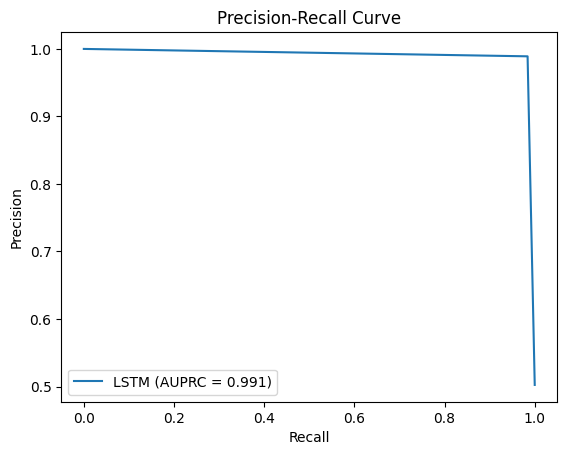

In [14]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_binary)
auprc = auc(recall, precision)
plt.plot(recall, precision, label='LSTM (AUPRC = {:.3f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

##### Inference
* LSTM has performed well on unseen Test dataset with good precision and recall 

##### Adaptive Random Forest 

In [16]:
import pickle
with open ("ARF_evaluator.pkl","rb" ) as file :
    evaluator=pickle.load(file)

In [17]:
arf_y_pred=evaluator.predict(data)

In [18]:
arf_y_pred

[array([1, 1, 1, ..., 1, 0, 0])]

##### Combined Predictions

In [19]:
y_pred_binary.shape

(50000, 1)

In [20]:
arf_predictions=np.array(arf_y_pred[0])

In [21]:
# Reshape arf_predictions to match the shape of y_pred_binary
Arf_predtn = np.reshape(arf_predictions, (-1, 1))

##### Performing Weighted Voting

In [31]:
lstm_weight= 0.6
arf_weight=0.4
combined_predictions_t= ((lstm_weight * y_pred_binary + arf_weight * Arf_predtn)/(lstm_weight+arf_weight))
# print(combined_predictions)
combined_predictions_t = (combined_predictions_t > 0.5).astype(int)
combined_predictions_t

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

#### Examining Misclassifications

In [24]:
def create_table_diff(target, y_pred):
    target = np.reshape(target, -1)
    y_pred = np.reshape(y_pred, -1)
    return pd.DataFrame({"actual values": target,
                         "predicted values": y_pred,
                         "diff": np.abs(target - y_pred)})

In [38]:
df_pred=create_table_diff(y_test,combined_predictions_t.astype(int))

In [39]:
df_pred[df_pred['diff'] == 1]

,actual values,predicted values,diff
42,0,1,1
44,0,1,1
152,0,1,1
224,1,0,1
279,0,1,1
...,...,...,...
49779,0,1,1
49877,1,0,1
49927,1,0,1
49928,1,0,1


##### Out of 50,000 rows, combined model is missclassifying 672 values i.e approximately 1.34% which is satisfactory and better than traditional machine learning approaches.

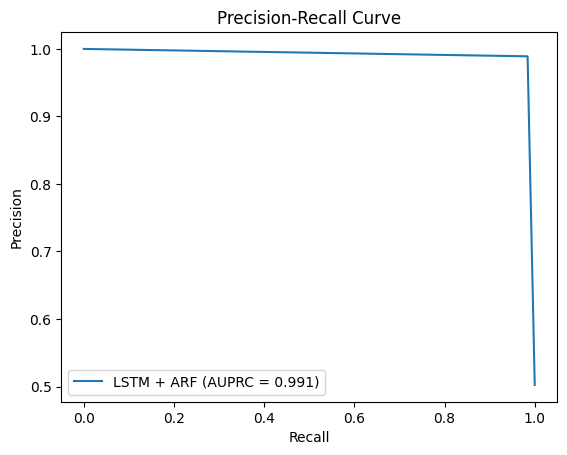

In [35]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test, combined_predictions_t.astype(int))
auprc = auc(recall, precision)
plt.plot(recall, precision, label='LSTM + ARF (AUPRC = {:.3f})'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### Combined Model Performance Metrics

In [37]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, combined_predictions_t.astype(int))
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, combined_predictions_t.astype(int))
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, combined_predictions_t.astype(int))
print('Recall: %f' % recall)

Accuracy: 0.986560
Precision: 0.989038
Recall: 0.984155


In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, combined_predictions_t.astype(int))

array([[24607,   274],
       [  398, 24721]])

### From the above findings, we can conclude that our proposed model provides a comprehensive solution for real-time fraud detection.